Use GPyTorch
Use Periodic kernel
Eclipsing binary + Pulsation + noise
Sample the input data so we can consider more

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [6]:
def plot_data(X, Y):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Plot observations
    plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])
    
def plot_lomb_scargle_periodogram(x, y, min_freq, max_freq, frequencies=None):
    if frequencies is not None:
        power = LombScargle(x, y).power(frequencies)
    else:
        frequencies, power = LombScargle(x, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    plt.figure(figsize=(35, 5))
    plt.plot(frequencies, power)
    plt.xlabel("frequency"), plt.ylabel("power")
    return frequencies, power

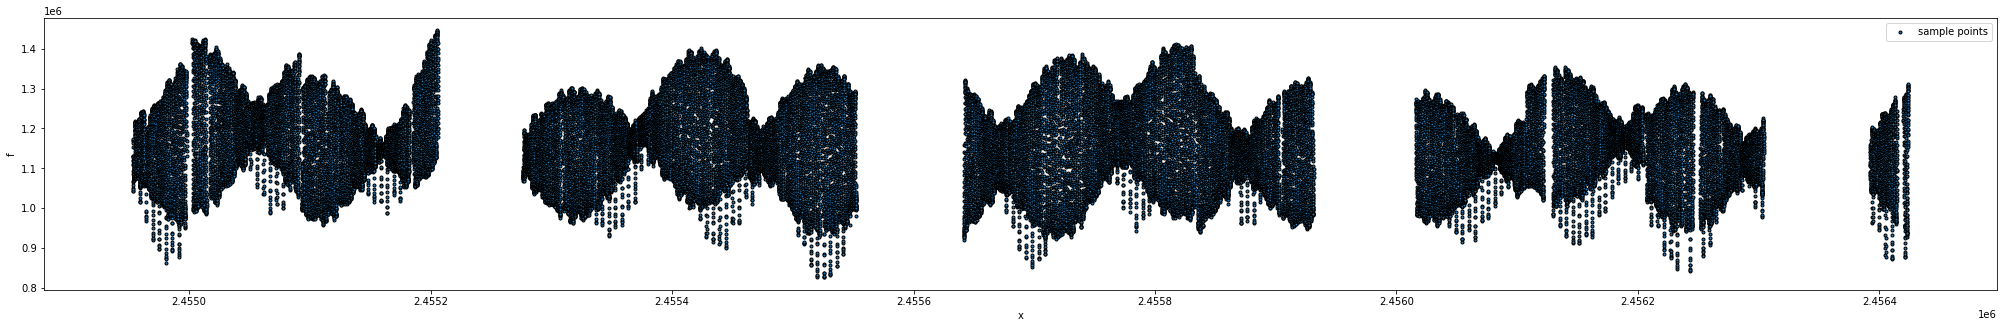

In [7]:
plot_data(X, Y)

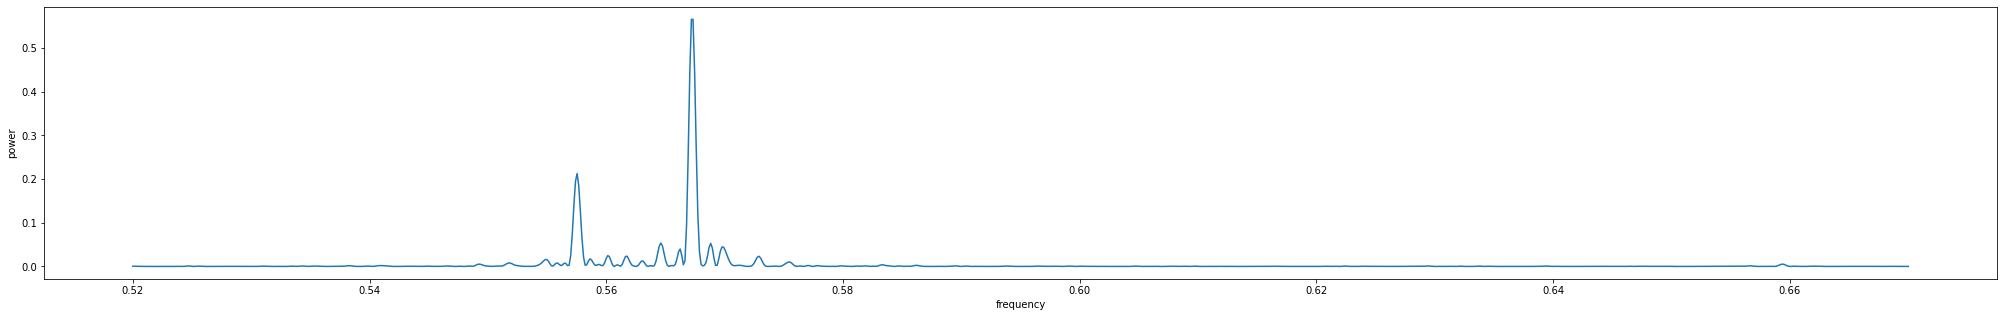

In [8]:
frequencies, power = plot_lomb_scargle_periodogram(X, Y, 0.52, 0.67)

In [9]:
N_samples = 8

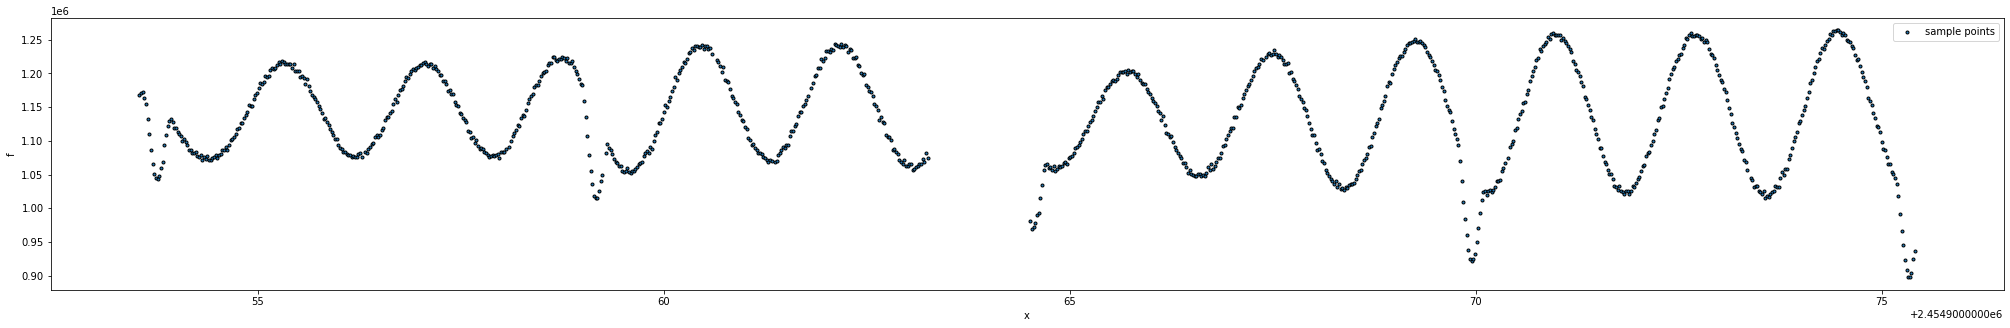

In [10]:
plot_data(X[:1000], Y[:1000])

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
def plot_kernel_samples(model, x, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    for i in range(nr_of_samples):
        Y_sample = model(x).sample()
        N = Y_sample.shape[0]
        plt.plot(range(N), Y_sample)

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [12]:
X_part, Y_part = X[1::N_samples], Y[1::N_samples]
N_part = X_part.shape[0]   # Use a number that can be divided by 4. N//4

X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

In [13]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [14]:
# normalize labels
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

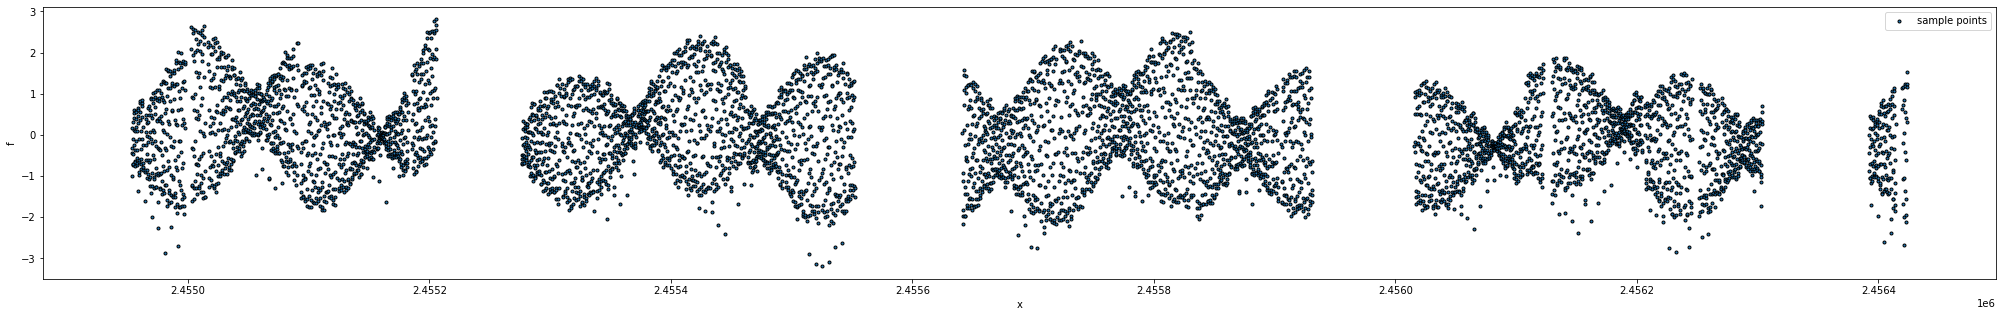

In [15]:
plot_data(X_part, Y_part)

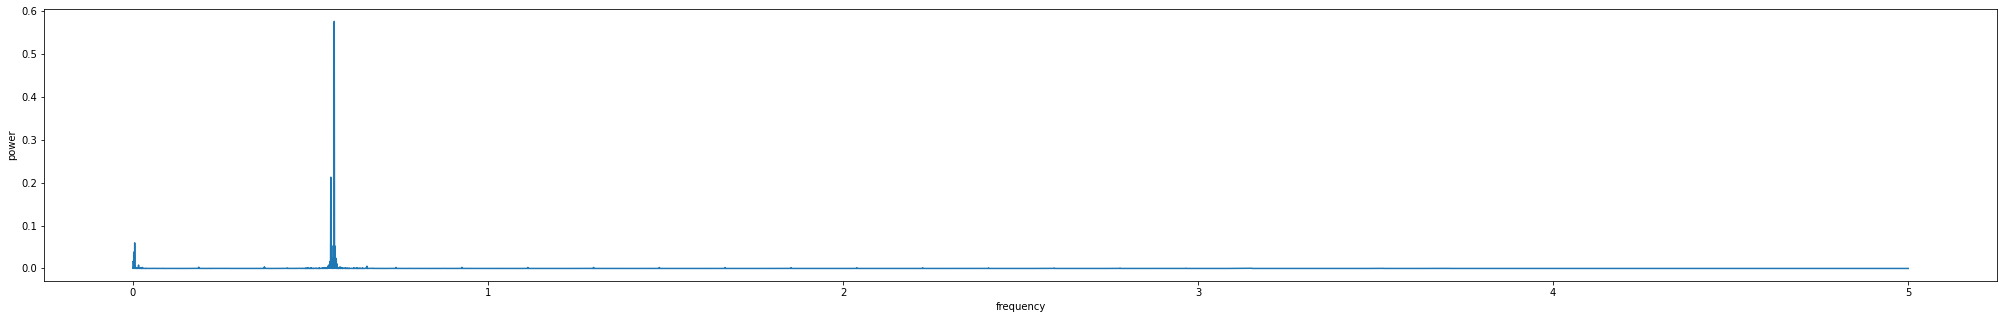

In [16]:
frequencies, power = plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [17]:
Y_part.cpu().numpy().mean()

8.66168765156225e-16

In [18]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # Periodic kernel for the Eclipsing Binary
        self.eb_kernel = gpytorch.kernels.PeriodicKernel()
        self.eb_kernel.period_length = 5.4
        self.eb_kernel.lengthscale = 0.001
        # Periodic kernel for the Pulsations
        self.pulse_kernel = gpytorch.kernels.PeriodicKernel()
        self.pulse_kernel.period_length = 1.77
        self.pulse_kernel.lengthscale = 0.001
        # RBF kernel for the uncorrelated noise
        self.noise_kernel = gpytorch.kernels.RBFKernel()
        
        # No solution yet for the non-stationary instrumentation noise
        self.covar_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(self.eb_kernel),
            gpytorch.kernels.ScaleKernel(self.pulse_kernel),
            gpytorch.kernels.ScaleKernel(self.noise_kernel),
        )
#        self.covar_module.period_length_prior = NormalPrior(loc=5.4, scale=0.1)
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [19]:
if USE_CUDA:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [29]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
final_params = list(all_params - {model.covar_module.kernels[0].base_kernel.raw_period_length, model.covar_module.kernels[1].base_kernel.raw_period_length})
optimizer = torch.optim.Adam(final_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period 0: %.3f   period 1: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.kernels[0].base_kernel.period_length.item(),
        model.covar_module.kernels[1].base_kernel.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.520   period 0: 5.400   period 1: 1.770   noise: 0.016
Iter 2/50 - Loss: 0.477   period 0: 5.400   period 1: 1.770   noise: 0.018
Iter 3/50 - Loss: 0.463   period 0: 5.400   period 1: 1.770   noise: 0.021
Iter 4/50 - Loss: 0.448   period 0: 5.400   period 1: 1.770   noise: 0.024
Iter 5/50 - Loss: 0.443   period 0: 5.400   period 1: 1.770   noise: 0.028
Iter 6/50 - Loss: 0.442   period 0: 5.400   period 1: 1.770   noise: 0.031
Iter 7/50 - Loss: 0.427   period 0: 5.400   period 1: 1.770   noise: 0.032
Iter 8/50 - Loss: 0.434   period 0: 5.400   period 1: 1.770   noise: 0.033
Iter 9/50 - Loss: 0.449   period 0: 5.400   period 1: 1.770   noise: 0.032
Iter 10/50 - Loss: 0.442   period 0: 5.400   period 1: 1.770   noise: 0.031
Iter 11/50 - Loss: 0.421   period 0: 5.400   period 1: 1.770   noise: 0.029
Iter 12/50 - Loss: 0.424   period 0: 5.400   period 1: 1.770   noise: 0.027
Iter 13/50 - Loss: 0.427   period 0: 5.400   period 1: 1.770   noise: 0.025
Iter 14/50 - Loss: 0.

In [30]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))

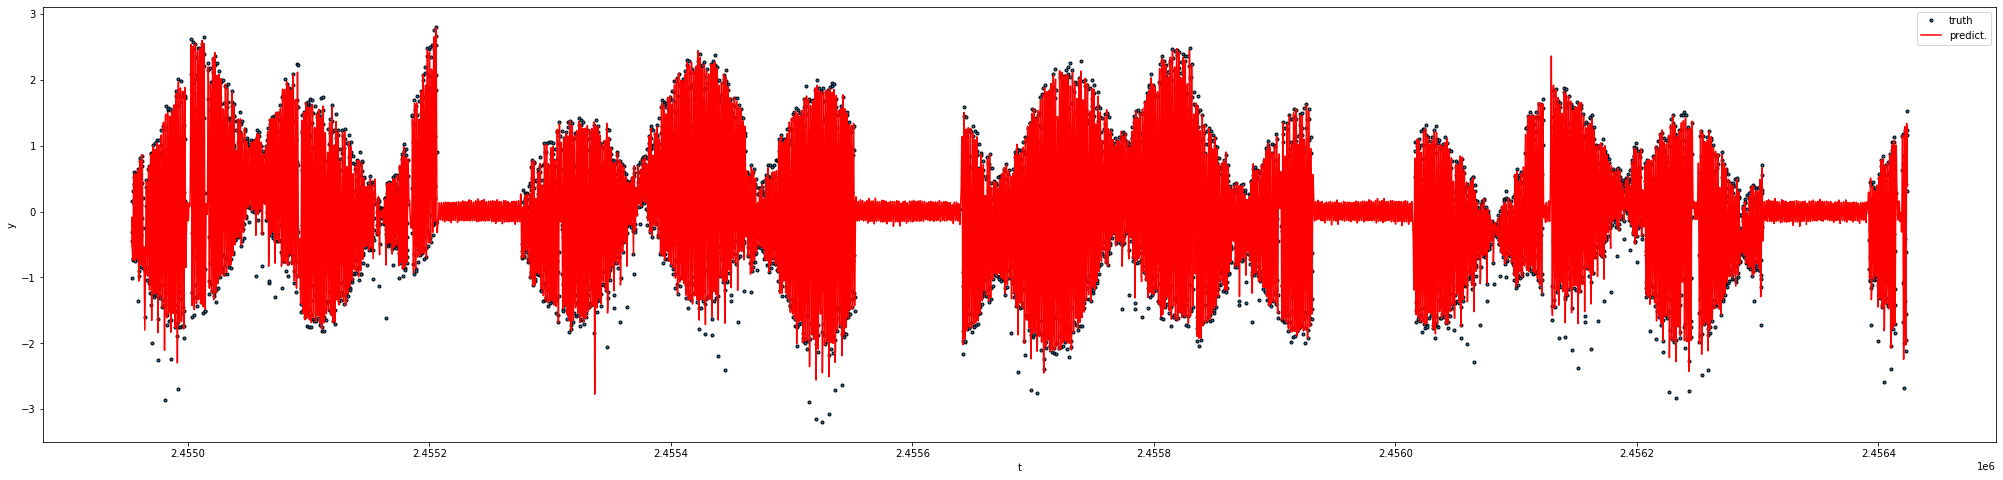

In [31]:
with torch.no_grad():
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

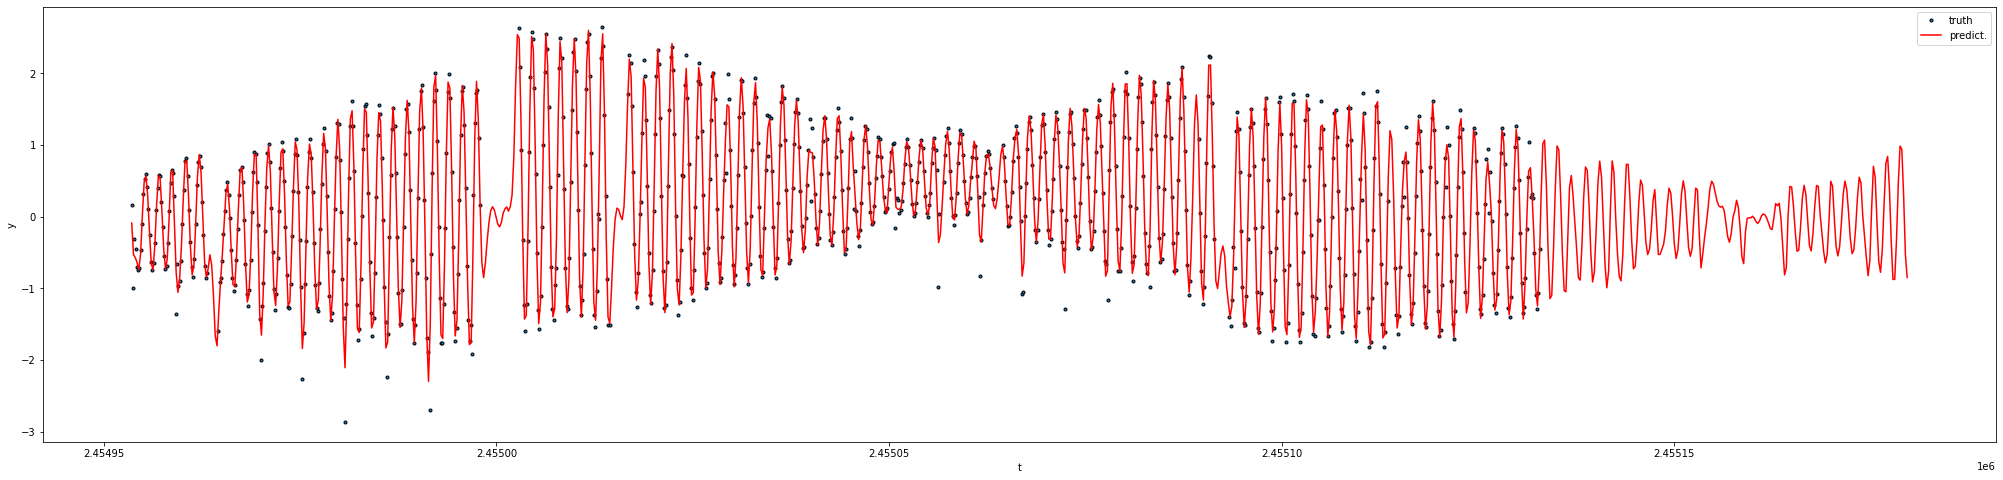

In [32]:
# Plot subset of the series for better investigation
with torch.no_grad():
    plot_series(X_part.cpu().numpy()[:1000], Y_part.cpu().numpy()[:1000], X_part_smooth.cpu().numpy()[:1000], observed_pred.mean.cpu().numpy()[:1000])

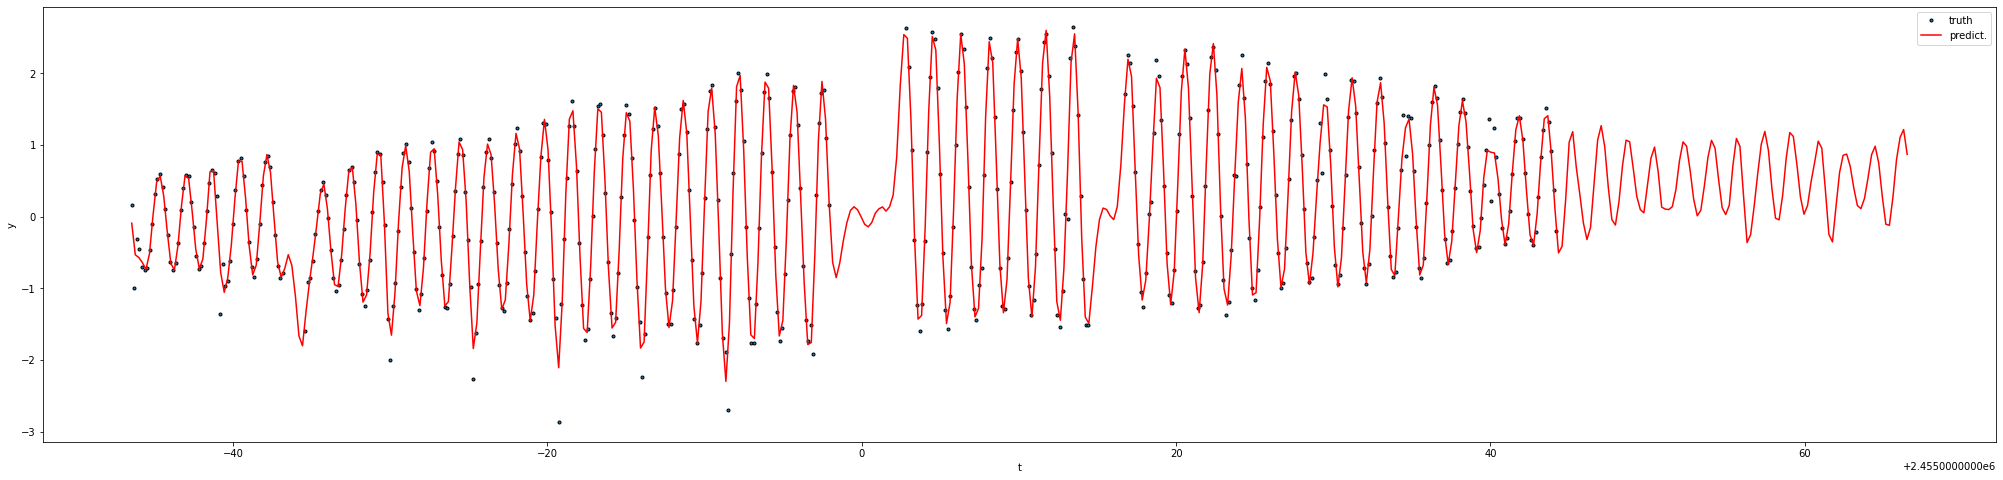

In [37]:
# Plot subset of the series for better investigation
with torch.no_grad():
    plot_series(X_part.cpu().numpy()[:500], Y_part.cpu().numpy()[:500], X_part_smooth.cpu().numpy()[:500], observed_pred.mean.cpu().numpy()[:500])

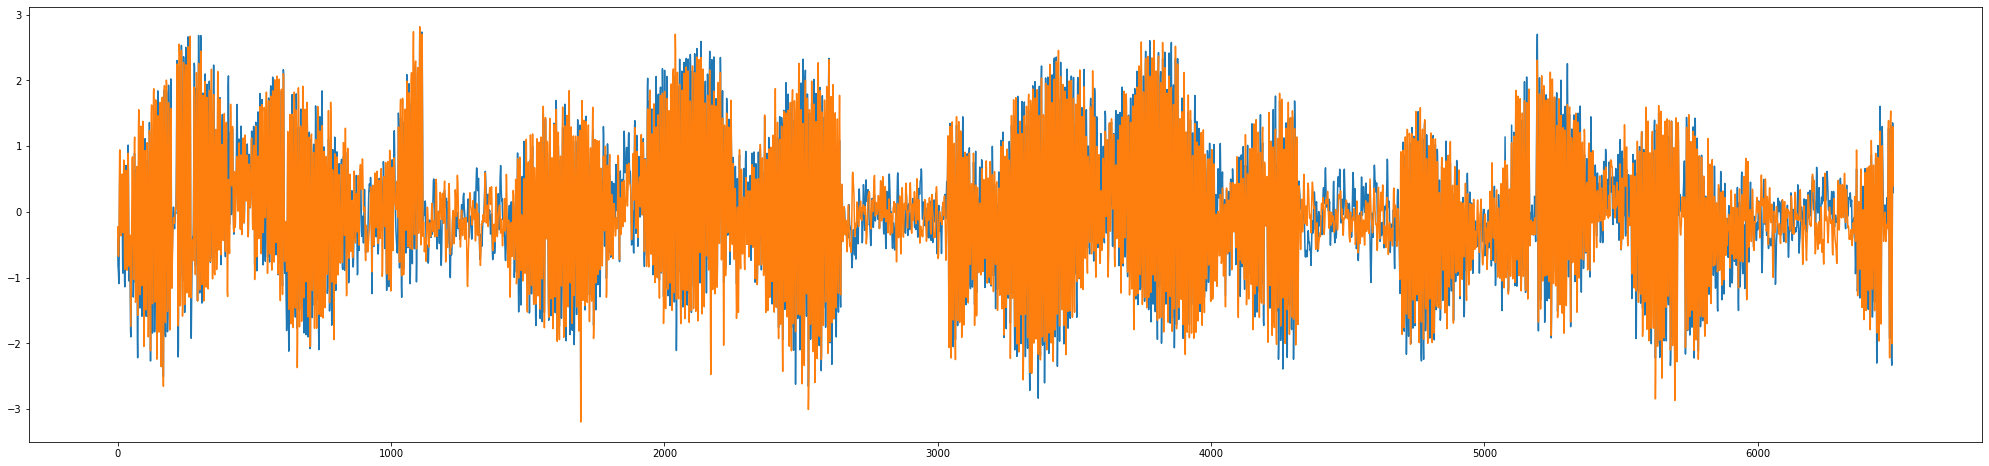

In [33]:
# Plot some samples of the kernel
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_kernel_samples(model, X_part_smooth, nr_of_samples=2)

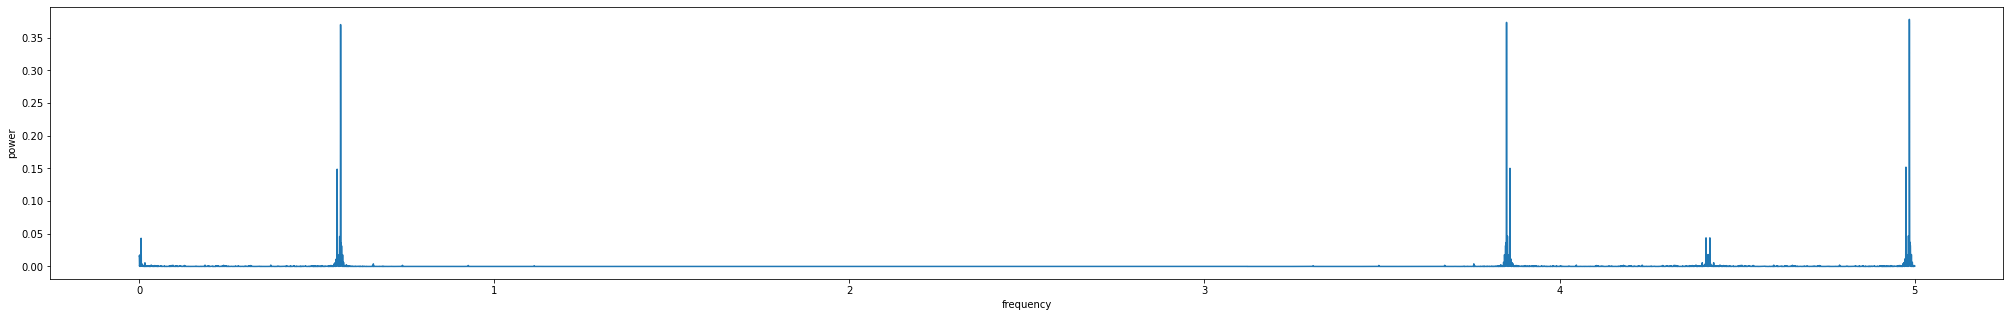

In [34]:
# Plot the periodogram of one sample
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_sample = model(X_part_smooth).sample()
    frequency, power = LombScargle(X_part_smooth, Y_sample).autopower(minimum_frequency=0.0, maximum_frequency=5)
    plt.figure(figsize=(35, 5))
    plt.plot(frequency, power)
    plt.xlabel("frequency"), plt.ylabel("power")

In [35]:
with torch.no_grad():
    residuals = Y_part.cpu()-observed_pred.mean.cpu().numpy()

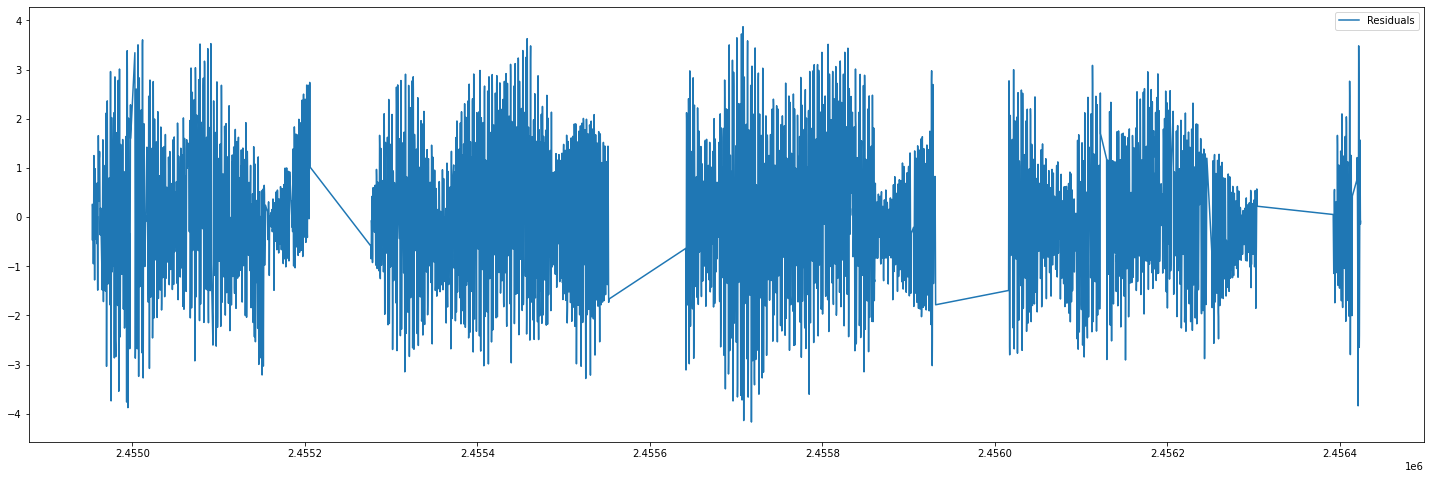

In [36]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [28]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part))
    
np.sqrt(np.nanmean((observed_pred.mean.cpu().numpy()-Y_part.cpu().numpy())**2))

0.10068695740776587